In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
import astropy

In [2]:
#from platform import python_version
#python_version()

In [3]:
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams['axes.linewidth'] = 1.0


font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

## Getting the directory name

In [4]:
import os
directory_path = os.getcwd()
nome_aglo = directory_path.split('/')[-1]
nome_aglo

'Berkeley_20'

## Getting RA&DEC from Bica 2019

In [5]:
df = pd.read_csv('../../lista.txt', comment= '#')
ra, dec = df.loc[df['Nome'] == nome_aglo]['_RAJ2000'].values[0], df.loc[df['Nome'] == nome_aglo]['_DEJ2000'].values[0]
ra, dec

(83.15417, 0.18611)

## Querying the data

In [6]:
tables = Gaia.load_tables(only_names=True)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


In [7]:
meta = Gaia.load_table('gaiadr3.gaia_source')
meta

Retrieving table 'gaiadr3.gaia_source'


In [8]:
query = """SELECT 
ra, dec, pmra, pmra_error, pmdec, pmdec_error, bp_rp, phot_g_mean_mag, parallax, parallax_error, radial_velocity, radial_velocity_error, l,b
FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(POINT('ICRS',ra,dec),
CIRCLE('ICRS', """ +  str(ra) + ',' + str(dec) + ',' + ' 0.2))'

In [9]:
job = Gaia.launch_job_async(query)
job

INFO: Query finished. [astroquery.utils.tap.core]


In [10]:
data = job.get_results()
len(data)

2367

In [11]:
#data

## Converting to pandas

In [12]:
df = data.to_pandas()
df

,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b
0,83.130000,0.024881,NaN,NaN,NaN,NaN,0.032164,21.009258,NaN,NaN,NaN,NaN,203.621604,-17.472247
1,83.257874,0.057711,2.408064,0.502111,-3.074558,0.409110,1.146027,19.979197,0.439876,0.482129,NaN,NaN,203.655456,-17.344238
2,83.153523,-0.008510,-2.080018,0.178460,-0.687815,0.158020,1.478388,18.586525,0.543263,0.183739,NaN,NaN,203.664140,-17.467550
3,83.142020,-0.007808,11.558738,0.642386,9.140640,0.570120,2.289410,19.768946,0.798167,0.540839,NaN,NaN,203.657729,-17.477318
4,83.189096,-0.007894,-0.127778,0.572463,1.085237,0.438353,2.027580,17.680628,1.480789,0.498530,NaN,NaN,203.681395,-17.436009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2362,83.287381,0.331005,1.082818,0.694580,-0.025473,0.555356,1.453924,20.280828,-0.879522,0.634926,NaN,NaN,203.418952,-17.187543
2363,83.286419,0.333526,0.901165,0.538844,-0.664439,0.419411,2.040854,19.831381,0.950486,0.459136,NaN,NaN,203.416153,-17.187179
2364,83.286134,0.333036,-1.253134,1.248158,0.690360,0.849323,1.278822,20.532476,-0.668638,0.976603,NaN,NaN,203.416461,-17.187665
2365,83.268365,0.350286,0.805635,0.240618,-1.714537,0.198210,1.346308,18.803711,-0.212792,0.223719,NaN,NaN,203.391700,-17.194995


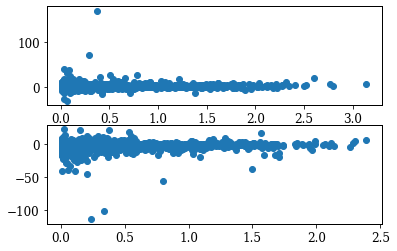

In [13]:
fig, ax = plt.subplots(2)

ax[0].scatter(df.pmra_error,df.pmra)
ax[1].scatter(df.pmdec_error,df.pmdec)

In [14]:
print(np.mean(df.pmdec), np.mean(df.pmdec_error)) ## por que pmra tem um erro muito maior?
print(np.mean(df.pmra), np.mean(df.pmra_error))

-1.5034396887424615 0.38468191027641296
1.3175847898718165 0.4333019554615021


## Applying better conditions to the variables

In [15]:
condicao = np.abs(0.5*df.pmra) < df.pmra_error
condicao2 = np.abs(0.5*df.pmdec) < df.pmdec_error
condicao3 = np.abs(0.5*df.parallax) < df.parallax_error


df_condicionado = df.drop(df[condicao|condicao2|condicao3].index) #
len(df_condicionado),len(df)

(916, 2367)

## Dropping uknown values of pmra, pmdec or parallax.

In [16]:
ndf = df_condicionado.dropna(how='any',subset=['pmra', 'pmdec', 'parallax'])
ndf

,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b
2,83.153523,-0.008510,-2.080018,0.178460,-0.687815,0.158020,1.478388,18.586525,0.543263,0.183739,NaN,NaN,203.664140,-17.467550
5,83.195395,-0.005897,2.798615,0.103835,-2.903868,0.089913,1.164801,17.635563,0.415407,0.106830,NaN,NaN,203.682712,-17.429521
8,83.211534,-0.003513,0.968379,0.110644,-3.950925,0.098014,2.056555,17.789942,1.043257,0.123378,NaN,NaN,203.688600,-17.414204
12,83.198251,-0.008039,1.909492,0.143238,-5.802869,0.129748,2.533644,18.232862,1.644740,0.159400,NaN,NaN,203.686115,-17.428036
17,83.163160,-0.005416,0.284150,0.108652,-1.857005,0.090453,0.989645,17.539066,0.367677,0.105645,NaN,NaN,203.666120,-17.457606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,83.118092,0.380129,3.758200,0.336191,3.944639,0.282967,2.498821,19.192734,1.172743,0.322976,NaN,NaN,203.288833,-17.312558
2352,83.071336,0.364528,0.321753,0.060206,-3.685349,0.054982,1.209715,16.670483,0.374984,0.066953,NaN,NaN,203.279676,-17.361066
2355,83.087089,0.366894,1.262732,0.396665,-10.612107,0.342830,2.479229,19.363001,1.685534,0.386122,NaN,NaN,203.285419,-17.346109
2356,83.139356,0.377923,1.413995,0.104917,-4.501810,0.094573,2.014454,17.551716,1.021271,0.108227,NaN,NaN,203.301543,-17.294958


In [17]:
#from sklearn.cluster import DBSCAN
#from sklearn.metrics import silhouette_score
#from sklearn.metrics import v_measure_score
from sklearn.preprocessing import StandardScaler

## Creating the arrays to perform the 5-D HDBSCAN fit

In [18]:
X = np.dstack((ndf['pmra'],ndf['pmdec']))[0]
cincoD = np.dstack((ndf['pmra'],ndf['pmdec'],ndf['ra'],ndf['dec'],ndf['parallax']))[0]

In [19]:
sc = StandardScaler()

escalada = sc.fit_transform(cincoD)

## Performing the HDBSCAN

In [20]:
import hdbscan

Estimated no. of clusters: 1
Estimated no. of noise points: 206
Estimated no. points clustered: 505


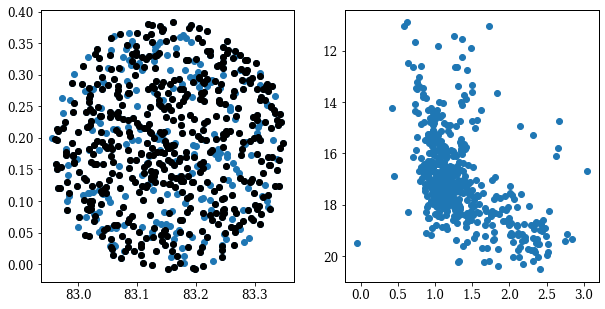

In [21]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=500, min_samples = 1, allow_single_cluster=True, cluster_selection_method = 'eom', metric = 'euclidean').fit(cincoD)

labels = clusterer.labels_


ndf = ndf.assign(labels=labels)


N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

n_noise = list(clusterer.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

n_in = list(clusterer.labels_).count(0)
print('Estimated no. points clustered: %d' % n_in)

subset = ndf[ndf.labels == 0]

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(subset.ra,subset.dec, color = 'k', zorder = 100)
ax[0].scatter(ndf.ra,ndf.dec)

ax[1].scatter(subset['bp_rp'],subset['phot_g_mean_mag'])
ax[1].invert_yaxis()


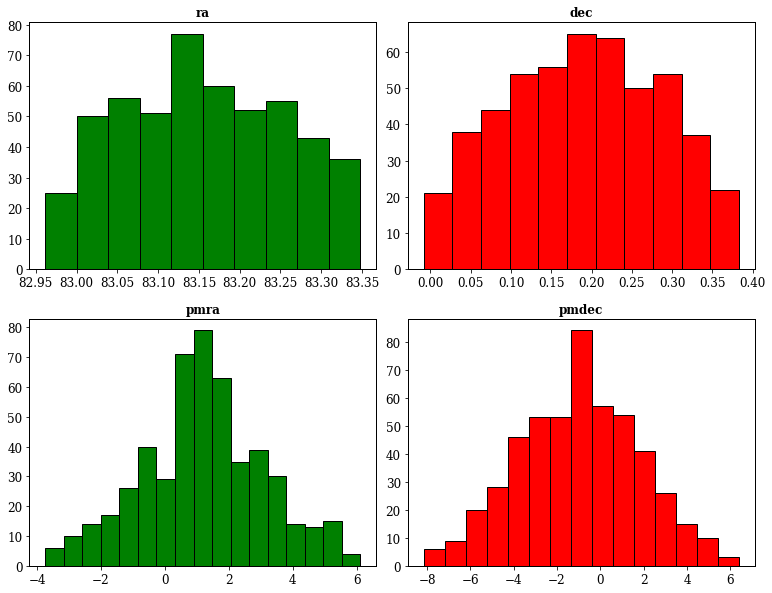

In [22]:
fig = plt.figure(figsize = (13,10))
ax1 = fig.add_subplot(4,4, (1,6))
ax2 = fig.add_subplot(4,4, (9,14))
ax3 = fig.add_subplot(4,4, (3,8))
ax4 = fig.add_subplot(4,4, (11,16))

optimal_bin = np.histogram_bin_edges(subset['ra'], bins = 'fd')
ax1.hist(subset['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['pmra'], bins = 'fd')
ax2.hist(subset['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['dec'], bins = 'fd')
ax3.hist(subset['dec'], optimal_bin,  ec = 'k', color = 'red');

optimal_bin = np.histogram_bin_edges(subset['pmdec'], bins = 'fd')
ax4.hist(subset['pmdec'], optimal_bin,  ec = 'k', color = 'red');

ax1.set_title('ra', fontweight = 'bold')
ax2.set_title('pmra', fontweight = 'bold')
ax3.set_title('dec', fontweight = 'bold')
ax4.set_title('pmdec', fontweight = 'bold')

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)


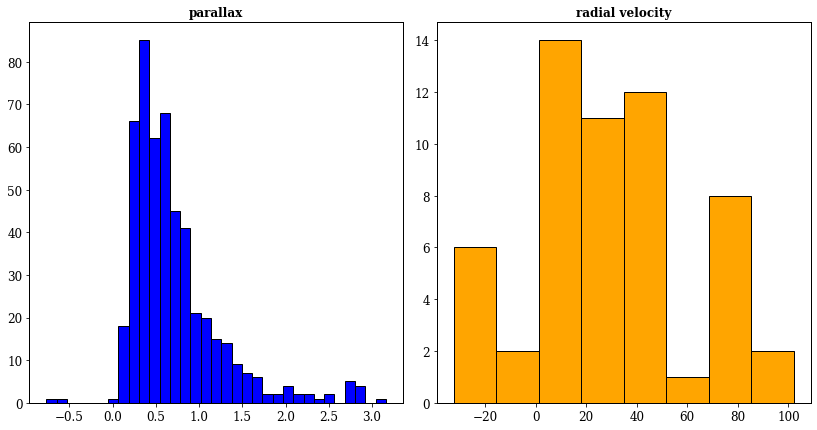

In [23]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(2,4, (1,6))

optimal_bin = np.histogram_bin_edges(subset['parallax'], bins = 'fd')
ax1.hist(subset['parallax'], optimal_bin, ec = 'k',color = 'blue');

ax2 = fig.add_subplot(2,4, (3,8))

ra_vel = subset.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')
ax2.hist(ra_vel.radial_velocity, optimal_bin, ec = 'k',color = 'orange');

ax1.set_title('parallax', fontweight = 'bold')
ax2.set_title('radial velocity', fontweight = 'bold');

## Constructing a RDP and histograms of the clusters parameters

Text(0, 0.5, 'stellar density (arcsec$^{-2}$)')

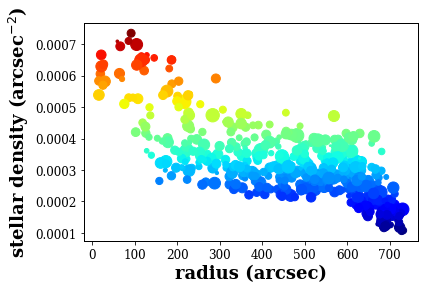

In [24]:
from astropy.coordinates import SkyCoord
from astropy import units
from sklearn.neighbors import NearestNeighbors


catalog = SkyCoord(ra=subset['ra']*units.degree, dec=subset['dec']*units.degree, frame='fk5')

nstar = len(subset)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([subset['ra']*np.cos(subset['dec']*np.pi/180.0), subset['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(subset['ra'], weights=den_data)
std_x = np.average((subset['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(subset['dec'], weights=den_data)
std_y = np.average((subset['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value

#.criando figura do RDP

import matplotlib.cm as cm
cor = cm.get_cmap('jet')

fig, ax = plt.subplots()#1,1,figsize=(10,11))
ax.scatter(radii,den_data, s=(max(subset['phot_g_mean_mag'])-subset['phot_g_mean_mag'])*20, c=den_data/3600**2, cmap = cor, label='data')
ax.set_xlabel('radius (arcsec)', fontsize=18, fontweight='bold')
ax.set_ylabel('stellar density (arcsec$^{-2}$)', fontsize=18, fontweight='bold')



## Gaussian fit

In [25]:
def gaussiana(x, amp, mu, sigma):
    return amp*np.exp(-(x-mu)**2/(2*sigma**2))

from lmfit.models import GaussianModel

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 33
    # variables        = 3
    chi-square         = 2008.50043
    reduced chi-square = 66.9500142
    Akaike info crit   = 141.584991
    Bayesian info crit = 146.074514
[[Variables]]
    amplitude:  54.4067652 +/- 3.55045292 (6.53%) (init = 62.57704)
    center:     0.47676727 +/- 0.02174651 (4.56%) (init = 0.4612657)
    sigma:      0.28860447 +/- 0.02174698 (7.54%) (init = 0.2454001)
    fwhm:       0.67961158 +/- 0.05121022 (7.54%) == '2.3548200*sigma'
    height:     75.2072892 +/- 4.90781152 (6.53%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


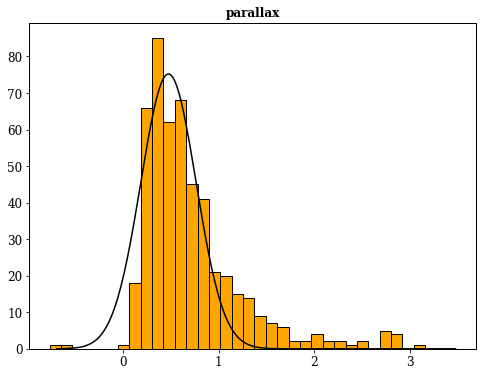

In [26]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['parallax']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'orange');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(0.9*bins[0],1.1*bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('parallax', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 10
    # variables        = 3
    chi-square         = 467.282482
    reduced chi-square = 66.7546403
    Akaike info crit   = 44.4434887
    Bayesian info crit = 45.3512440
[[Variables]]
    amplitude:  27.0443617 +/- 2.60453213 (9.63%) (init = 16.75303)
    center:     83.1547576 +/- 0.01407528 (0.02%) (init = 83.16766)
    sigma:      0.16711810 +/- 0.02121449 (12.69%) (init = 0.1073912)
    fwhm:       0.39353304 +/- 0.04995630 (12.69%) == '2.3548200*sigma'
    height:     64.5599730 +/- 4.32043233 (6.69%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.855


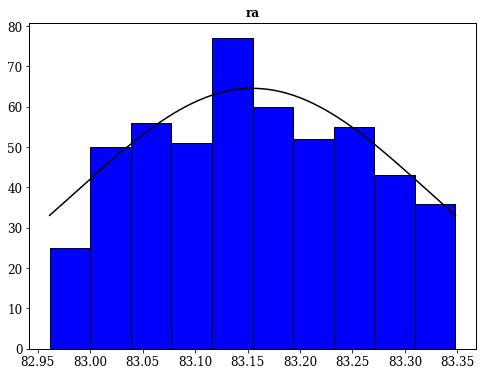

In [27]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['ra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_ra = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('ra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 17
    # variables        = 3
    chi-square         = 1335.10792
    reduced chi-square = 95.3648512
    Akaike info crit   = 80.1804190
    Bayesian info crit = 82.6800591
[[Variables]]
    amplitude:  300.443014 +/- 24.3312900 (8.10%) (init = 138.6867)
    center:     1.19713048 +/- 0.17605855 (14.71%) (init = 1.18185)
    sigma:      1.88570635 +/- 0.17688472 (9.38%) (init = 0.6163852)
    fwhm:       4.44049903 +/- 0.41653167 (9.38%) == '2.3548200*sigma'
    height:     63.5620849 +/- 5.14319934 (8.09%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.580


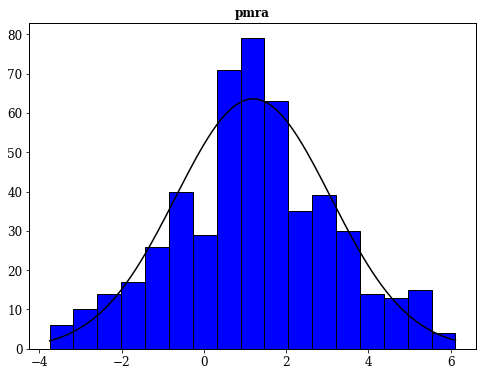

In [28]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmra= [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 11
    # variables        = 3
    chi-square         = 159.772605
    reduced chi-square = 19.9715757
    Akaike info crit   = 35.4344195
    Bayesian info crit = 36.6281053
[[Variables]]
    amplitude:  22.8195026 +/- 1.00848768 (4.42%) (init = 15.50285)
    center:     0.19252701 +/- 0.00630759 (3.28%) (init = 0.1872331)
    sigma:      0.14341565 +/- 0.00827188 (5.77%) (init = 0.1174458)
    fwhm:       0.33771804 +/- 0.01947879 (5.77%) == '2.3548200*sigma'
    height:     63.4774859 +/- 2.32766527 (3.67%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.772


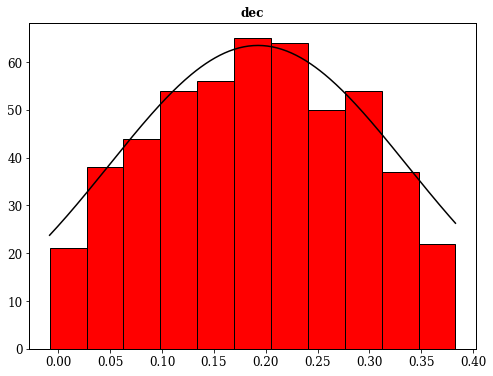

In [29]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['dec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_dec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('dec', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 15
    # variables        = 3
    chi-square         = 476.810470
    reduced chi-square = 39.7342058
    Akaike info crit   = 57.8860331
    Bayesian info crit = 60.0101837
[[Variables]]
    amplitude:  531.189267 +/- 26.4225786 (4.97%) (init = 631.9052)
    center:    -0.96075632 +/- 0.17861052 (18.59%) (init = -1.400533)
    sigma:      3.12600163 +/- 0.18139651 (5.80%) (init = 2.600433)
    fwhm:       7.36117117 +/- 0.42715613 (5.80%) == '2.3548200*sigma'
    height:     67.7907092 +/- 3.36034007 (4.96%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.586


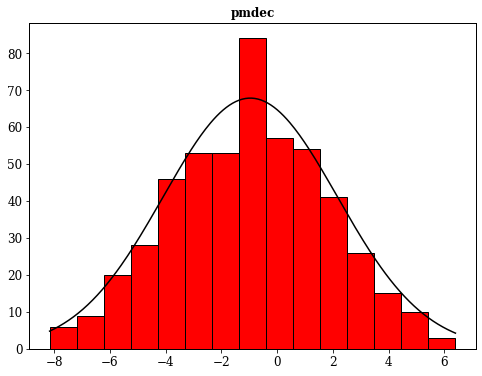

In [30]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmdec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmdec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmdec', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 8
    # variables        = 3
    chi-square         = 102.183835
    reduced chi-square = 20.4367670
    Akaike info crit   = 26.3786556
    Bayesian info crit = 26.6169802
[[Variables]]
    amplitude:  1083.81241 +/- 291.579624 (26.90%) (init = 1497.976)
    center:     24.3858510 +/- 11.1053331 (45.54%) (init = 39.63969)
    sigma:      36.7074848 +/- 11.9453967 (32.54%) (init = 38.40964)
    fwhm:       86.4395194 +/- 28.1292590 (32.54%) == '2.3548200*sigma'
    height:     11.7790314 +/- 3.07285792 (26.09%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.629


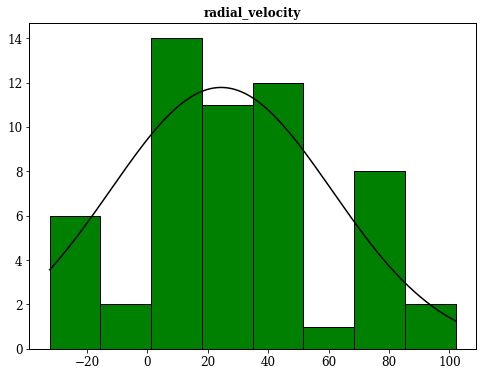

In [31]:
fig, ax = plt.subplots(figsize=(8,6))

ra_vel = subset.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')

data = ra_vel['radial_velocity']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'green');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]

valores_radial_velocity= [result.params['center'].value, result.params['sigma'].value]


xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('radial_velocity', fontweight = 'bold')

plt.show()

505
132


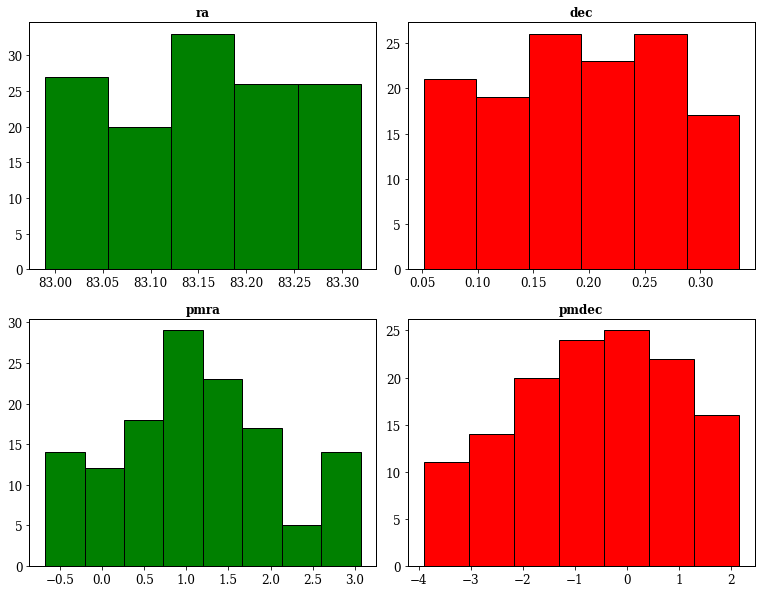

In [32]:
gmodel = GaussianModel()
clip_loop = subset

for i in range(1):
    print(len(clip_loop))
    data = clip_loop['ra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_ra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]
    
    data = clip_loop['dec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_dec = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]


    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


    sigma = 1

    paralaxe_up, paralaxe_down = valores_paralaxe[0] + sigma*valores_paralaxe[1], valores_paralaxe[0] - sigma*valores_paralaxe[1]
    ra_up, ra_down = valores_ra[0] + sigma*valores_ra[1], valores_ra[0] - sigma*valores_ra[1]
    pmra_up, pmra_down = valores_pmra[0] + sigma*valores_pmra[1], valores_pmra[0] - sigma*valores_pmra[1]
    dec_up, dec_down = valores_dec[0] + sigma*valores_dec[1], valores_dec[0] - sigma*valores_dec[1]
    pmdec_up, pmdec_down = valores_pmdec[0] + sigma*valores_pmdec[1], valores_pmdec[0] - sigma*valores_pmdec[1]
    radvel_up, radvel_down = valores_radial_velocity[0] + sigma*valores_radial_velocity[1], valores_radial_velocity[0] - sigma*valores_radial_velocity[1]
    clip_loop = clip_loop.loc[(clip_loop.parallax < paralaxe_up ) & (clip_loop.parallax > paralaxe_down) & (clip_loop.ra>ra_down) & (clip_loop.ra<ra_up) & 
                              (clip_loop.dec>dec_down) & (clip_loop.dec<dec_up) & (clip_loop.pmra>pmra_down) & (clip_loop.pmra<pmra_up) & (clip_loop.pmdec>pmdec_down) 
                              & (clip_loop.pmdec<pmdec_up)  & (clip_loop.radial_velocity.isnull() | (clip_loop.radial_velocity>radvel_down) & (clip_loop.radial_velocity<radvel_up)) ]

    
print(len(clip_loop))

fig = plt.figure(figsize = (13,10))
ax1 = fig.add_subplot(4,4, (1,6))
ax2 = fig.add_subplot(4,4, (9,14))
ax3 = fig.add_subplot(4,4, (3,8))
ax4 = fig.add_subplot(4,4, (11,16))

optimal_bin = np.histogram_bin_edges(clip_loop['ra'], bins = 'fd')
ax1.hist(clip_loop['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['pmra'], bins = 'fd')
ax2.hist(clip_loop['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['dec'], bins = 'fd')
ax3.hist(clip_loop['dec'], optimal_bin,  ec = 'k', color = 'red');

optimal_bin = np.histogram_bin_edges(clip_loop['pmdec'], bins = 'fd')
ax4.hist(clip_loop['pmdec'], optimal_bin,  ec = 'k', color = 'red');

ax1.set_title('ra', fontweight = 'bold')
ax2.set_title('pmra', fontweight = 'bold')
ax3.set_title('dec', fontweight = 'bold')
ax4.set_title('pmdec', fontweight = 'bold')

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)


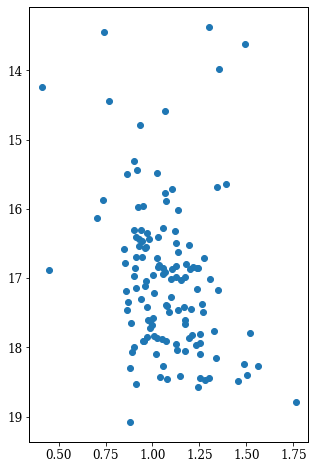

In [33]:
plt.figure(figsize=(5,8))
plt.scatter(clip_loop['bp_rp'],clip_loop['phot_g_mean_mag'])
plt.gca().invert_yaxis()

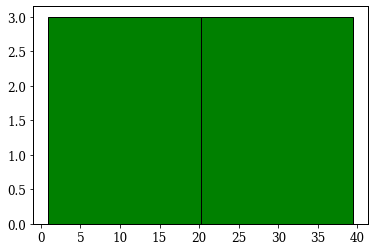

In [34]:
ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')

data = ra_vel['radial_velocity']

plt.hist(data, optimal_bin, ec = 'k',color = 'green');

Text(0, 0.5, 'stellar density (arcsec$^{-2}$)')

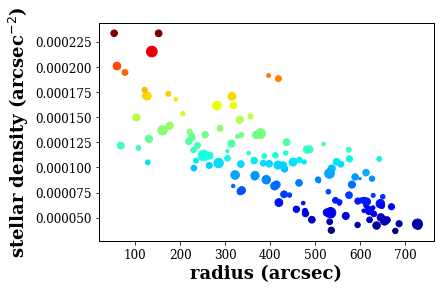

In [35]:
from astropy.coordinates import SkyCoord
from astropy import units

catalog = SkyCoord(ra=clip_loop['ra']*units.degree, dec=clip_loop['dec']*units.degree, frame='fk5')

nstar = len(clip_loop)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([clip_loop['ra']*np.cos(clip_loop['dec']*np.pi/180.0), clip_loop['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(clip_loop['ra'], weights=den_data)
std_x = np.average((clip_loop['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(clip_loop['dec'], weights=den_data)
std_y = np.average((clip_loop['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value


import matplotlib.cm as cm
cor = cm.get_cmap('jet')

fig, ax = plt.subplots()
ax.scatter(radii,den_data, s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*20, c=den_data/3600**2, cmap = cor, label='data')
ax.set_xlabel('radius (arcsec)', fontsize=18, fontweight='bold')
ax.set_ylabel('stellar density (arcsec$^{-2}$)', fontsize=18, fontweight='bold')



In [36]:
center

<SkyCoord (ICRS): (ra, dec) in deg
    (83.15927999, 0.199821)>

In [37]:
final = df.loc[(df.parallax < paralaxe_up ) & (df.parallax > paralaxe_down) & (df.ra>ra_down) & (df.ra<ra_up) & 
                              (df.dec>dec_down) & (df.dec<dec_up) & (df.pmra>pmra_down) & (df.pmra<pmra_up) & (df.pmdec>pmdec_down) 
                              & (df.pmdec<pmdec_up)  & (df.radial_velocity.isnull() | (df.radial_velocity>radvel_down) & (df.radial_velocity<radvel_up)) ]

In [38]:
clip_loop.to_csv('final_5d.csv', index=False)

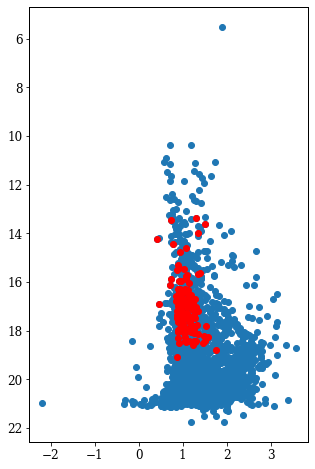

In [39]:
plt.figure(figsize=(5,8))
plt.scatter(df['bp_rp'],df['phot_g_mean_mag'])
plt.scatter(clip_loop['bp_rp'], clip_loop['phot_g_mean_mag'], color = 'red')
plt.gca().invert_yaxis()

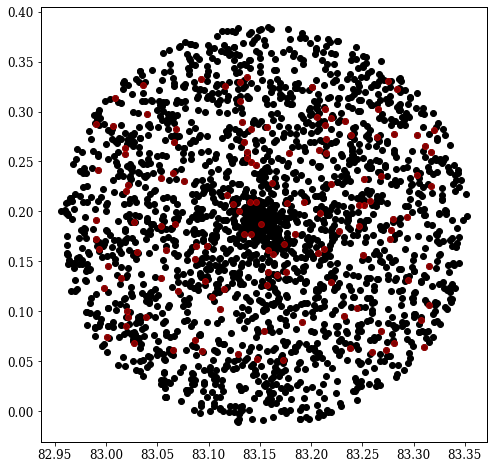

In [41]:
plt.figure(figsize=(8,8))
plt.scatter(df['ra'],df['dec'], color = 'k')
plt.scatter(clip_loop['ra'],clip_loop['dec'], color = 'red', alpha = 0.5)